In [1]:
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1489/1489), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 13187 (delta 1166), reused 1218 (delta 1098), pack-reused 11698 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (9970/9970), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793132 sha256=1207dfbe1f0c8333070049abb785eabffaba7577e24ce04801e1663852eb5616
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found exist

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

Define Leaky RNN

In [3]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))

        #implement how much the previous hidden layer activity should be maintained in the new activity
        h_new = hidden * (1-self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add a Linear output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [4]:
class sparseLeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, sparsity_level=0.5, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        self.sparsity_level = sparsity_level
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.apply_sparsity(sparsity_level)

    def apply_sparsity(self, sparsity_level):
      # Prune weights by setting a fraction to zero
        for param in [self.input2h.weight, self.h2h.weight]:
            mask = torch.rand_like(param) > sparsity_level
            param.data *= mask

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))

        #implement how much the previous hidden layer activity should be maintained in the new activity
        h_new = hidden * (1-self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class sparseRNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = sparseLeakyRNN(input_size, hidden_size, **kwargs)

        # Add a Linear output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [5]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np


class EIRecLinear(nn.Module):

    """Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal
        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))

        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T

        mask = mask_no_diag*E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)
        #First create a mask to remove the diagonal (matrix size hidden_size*hidden_size)
        #mask_no_diag = np.ones((self.hidden_size, self.hidden_size)) - np.eye(self.hidden_size)
        # Define the excitatory an inhibitory units with columns of 1s and -1s (use e_size and i_size)
        #E_I_unit_list = np.concatenate((np.ones((self.e_size, self.hidden_size)), -1*np.ones((self.i_size, self.hidden_size)))).T*np.eye(self.hidden_size)

        #mask = mask_no_diag@E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        print("EI Mask shape:", mask.shape)
        print("EI Mask values:", mask)


    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)


In [6]:
class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

In [7]:
class EIRNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

Determine dimensions

Get dataset

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


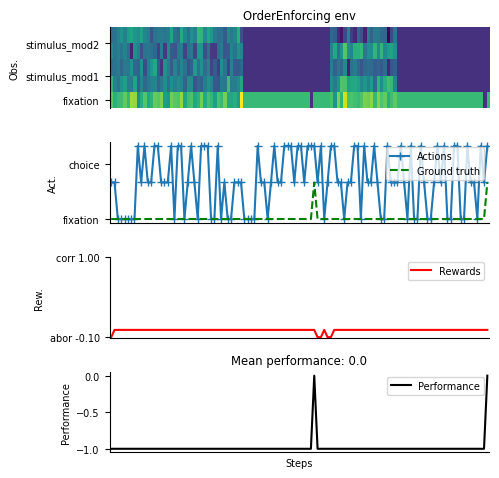

In [8]:
import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'SingleContextDecisionMaking-v0'
#task = 'PerceptualDecisionMakingDelayResponse-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

Train leaky RNN

EI Mask shape: (50, 50)
EI Mask values: [[ 0.  1.  1. ... -1. -1. -1.]
 [ 1.  0.  1. ... -1. -1. -1.]
 [ 1.  1.  0. ... -1. -1. -1.]
 ...
 [ 1.  1.  1. ... -0. -1. -1.]
 [ 1.  1.  1. ... -1. -0. -1.]
 [ 1.  1.  1. ... -1. -1. -0.]]
RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=5, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
sparseRNNNet(
  (rnn): sparseLeakyRNN(
    (input2h): Linear(in_features=5, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
EIRNNNet(
  (rnn): EIRNN(
    (input2h): Linear(in_features=5, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Step 100, LeakyRNN Loss 0.3689, sparseLeakyRNN Loss 0.4578, EIRNN Loss 0.5371, Time 14.4s
Step 200, LeakyRNN Loss 0.1133, sparseLeakyRNN Los

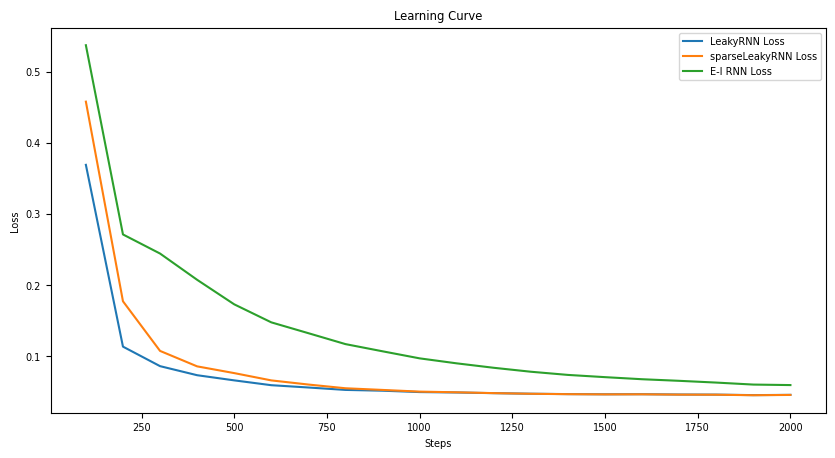

In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
import time
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the networks
hidden_size = 50
net = RNNNet(input_size, hidden_size, output_size) # LeakyRNN
sparse_net = sparseRNNNet(input_size, hidden_size, output_size, sparsity_level=0.5) # sparseLeakyRNN
EIRNN_net = EIRNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15) # E-I RNN
print(net)
print(sparse_net)
print(EIRNN_net)

# Use Adam optimizer for both networks
optimizer = optim.Adam(net.parameters(), lr=0.001)
sparse_optimizer = optim.Adam(sparse_net.parameters(), lr=0.001)
EIRNN_optimizer = optim.Adam(EIRNN_net.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values for LeakyRNN
sparse_loss_values = []  # List to store loss values for sparseLeakyRNN
EIRNN_loss_values = []  # List to store loss values for E-I RNN
running_loss = 0.0
sparse_running_loss = 0.0
EIRNN_running_loss = 0.0
start_time = time.time()
print_step = 100
steps = 2000
for i in range(steps):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers for both networks
    optimizer.zero_grad()
    sparse_optimizer.zero_grad()
    EIRNN_optimizer.zero_grad()

    # Forward pass for both networks
    output, activity = net(inputs)
    output = output.view(-1, output_size)
    sparse_output, sparse_activity = sparse_net(inputs)
    sparse_output = sparse_output.view(-1, output_size)
    EIRNN_output, EIRNN_activity = EIRNN_net(inputs)
    EIRNN_output = EIRNN_output.view(-1, output_size)

    # Compute loss for both networks
    loss = criterion(output, labels)
    sparse_loss = criterion(sparse_output, labels)
    EIRNN_loss = criterion(EIRNN_output, labels)

    # Backward pass for both networks
    loss.backward()
    sparse_loss.backward()
    EIRNN_loss.backward()

    # Update weights for both networks
    optimizer.step()
    sparse_optimizer.step()
    EIRNN_optimizer.step()

    # Update running losses
    running_loss += loss.item()
    sparse_running_loss += sparse_loss.item()
    EIRNN_running_loss += EIRNN_loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        sparse_average_loss = sparse_running_loss / print_step
        EIRNN_average_loss = EIRNN_running_loss / print_step
        print('Step {}, LeakyRNN Loss {:0.4f}, sparseLeakyRNN Loss {:0.4f}, EIRNN Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, average_loss, sparse_average_loss, EIRNN_average_loss, time.time() - start_time))
        loss_values.append(average_loss)
        sparse_loss_values.append(sparse_average_loss)
        EIRNN_loss_values.append(EIRNN_average_loss)
        running_loss = 0.0
        sparse_running_loss = 0.0
        EIRNN_running_loss = 0.0

# Plotting the learning curves on the same graph
plt.figure(figsize=(10,5))
plt.title("Learning Curve")

x_values = np.arange(print_step, steps + print_step, print_step)

plt.plot(x_values, loss_values, label='LeakyRNN Loss')
plt.plot(x_values, sparse_loss_values, label='sparseLeakyRNN Loss')
plt.plot(x_values, EIRNN_loss_values, label='E-I RNN Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500

activity_dict_sparse = {}
activity_dict_leaky = {}
activity_dict_EIRNN = {}
trial_infos_sparse = {}
trial_infos_leaky = {}
trial_infos_EIRNN = {}
stim_activity_leaky = [[], []]  # response for ground-truth 0 and 1
stim_activity_sparse = [[], []]  # response for ground-truth 0 and 1
stim_activity_EIRNN = [[], []]

for i in range(num_trial):
    env.new_trial()
    #env.new_trial()

    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)

    action_pred_sparse, rnn_activity_sparse = sparse_net(inputs)
    action_pred_sparse = action_pred_sparse.detach().numpy()
    choice = np.argmax(action_pred_sparse[-1, 0, :])
    correct_sparse = choice == gt[-1]
    trial_info_sparse = env.trial
   # print(trial_info_sparse)
    trial_info_sparse.update({'correct': correct_sparse, 'choice': choice})
    trial_infos_sparse[i] = trial_info_sparse

    rnn_activity_sparse = rnn_activity_sparse[:, 0, :].detach().numpy()
    activity_dict_sparse[i] = rnn_activity_sparse

    rnn_activity_sparse = rnn_activity_sparse[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity_sparse[env.trial['ground_truth']].append(rnn_activity_sparse)

    env.new_trial()
    #env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred_leaky, rnn_activity_leaky = net(inputs)

    action_pred_leaky = action_pred_leaky.detach().numpy()
    choice = np.argmax(action_pred_leaky[-1, 0, :])
    correct_leaky = choice == gt[-1]
    trial_info_leaky = env.trial
    #print(trial_info_leaky)
    trial_info_leaky.update({'correct': correct_leaky, 'choice': choice})
    trial_infos_leaky[i] = trial_info_leaky

    rnn_activity_leaky = rnn_activity_leaky[:, 0, :].detach().numpy()
    activity_dict_leaky[i] = rnn_activity_leaky

    rnn_activity_leaky = rnn_activity_leaky[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity_leaky[env.trial['ground_truth']].append(rnn_activity_leaky)

    env.new_trial()
    #env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred_EIRNN, rnn_activity_EIRNN = EIRNN_net(inputs)

    action_pred_EIRNN = action_pred_EIRNN.detach().numpy()
    choice = np.argmax(action_pred_EIRNN[-1, 0, :])
    correct_EIRNN = choice == gt[-1]

    # Log trial info




    trial_info_EIRNN = env.trial
    trial_info_EIRNN.update({'correct': correct_EIRNN, 'choice': choice})
    trial_infos_EIRNN[i] = trial_info_EIRNN

    # Log stimulus period activity


    rnn_activity_EIRNN = rnn_activity_EIRNN[:, 0, :].detach().numpy()
    activity_dict_EIRNN[i] = rnn_activity_EIRNN

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity_EIRNN = rnn_activity_EIRNN[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity_EIRNN[env.trial['ground_truth']].append(rnn_activity_EIRNN)

print(trial_infos_sparse.values())
print(trial_infos_leaky.values())
print(trial_infos_EIRNN.values())

print('Average performance for sparse RNN', np.mean([val['correct'] for val in trial_infos_sparse.values()]))
print('Average performance for leaky RNN', np.mean([val['correct'] for val in trial_infos_leaky.values()]))
print('Average performance for EI RNN', np.mean([val['correct'] for val in trial_infos_EIRNN.values()]))


dict_values([{'ground_truth': 0, 'other_choice': 0, 'context': 0, 'coh_0': 5, 'coh_1': 50, 'correct': False, 'choice': 2}, {'ground_truth': 0, 'other_choice': 1, 'context': 0, 'coh_0': 50, 'coh_1': 5, 'correct': False, 'choice': 2}, {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_0': 50, 'coh_1': 50, 'correct': True, 'choice': 2}, {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_0': 15, 'coh_1': 50, 'correct': True, 'choice': 2}, {'ground_truth': 0, 'other_choice': 0, 'context': 0, 'coh_0': 50, 'coh_1': 5, 'correct': False, 'choice': 2}, {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_0': 15, 'coh_1': 50, 'correct': True, 'choice': 2}, {'ground_truth': 0, 'other_choice': 1, 'context': 0, 'coh_0': 50, 'coh_1': 50, 'correct': False, 'choice': 2}, {'ground_truth': 0, 'other_choice': 1, 'context': 0, 'coh_0': 5, 'coh_1': 5, 'correct': False, 'choice': 2}, {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_0': 5, 'coh_1': 5, 'correct': True, 'choice': 2},

In [11]:
inputs = torch.from_numpy(env.ob[:, np.newaxis, :]).type(torch.float)
_, rnn_activity_sparse = sparse_net(inputs)
_, rnn_activity_leaky = net(inputs)
_, rnn_activity_EIRNN = EIRNN_net(inputs)

print("Sparse activity:", rnn_activity_sparse[-1, 0, :])
print("Leaky activity:", rnn_activity_leaky[-1, 0, :])
print("EIRNN activity:", rnn_activity_EIRNN[-1, 0, :])



Sparse activity: tensor([1.0969, 0.2898, 0.4057, 0.0000, 0.0000, 0.9140, 0.7629, 2.1733, 0.2521,
        0.0000, 0.6553, 0.8041, 0.0000, 0.4155, 0.0000, 1.0778, 0.0000, 0.7162,
        0.0000, 0.0000, 1.7189, 0.4104, 0.3896, 3.4247, 2.4210, 0.0000, 0.9376,
        0.0000, 1.8533, 1.8569, 0.6127, 0.3907, 0.0607, 2.1785, 0.0000, 0.0000,
        0.3563, 2.4197, 0.7170, 0.0000, 0.0000, 2.6873, 0.0000, 0.0000, 0.5208,
        0.0000, 0.3543, 0.0000, 0.9384, 0.0428], grad_fn=<SliceBackward0>)
Leaky activity: tensor([2.2478, 0.0000, 0.0000, 0.0000, 0.0000, 1.1380, 0.3458, 0.5260, 0.0000,
        0.3783, 1.2069, 2.5534, 1.2175, 2.1281, 0.0000, 0.6375, 0.0000, 1.5547,
        0.0000, 2.3035, 0.0000, 0.0152, 0.0000, 0.0000, 1.8374, 0.2105, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.2255, 0.0000, 0.0000, 0.5900, 0.3074,
        1.1893, 0.0000, 0.0000, 4.0965, 0.5456, 0.0000, 0.0000, 3.0481, 0.0000,
        0.7028, 0.0000, 0.4090, 0.0000, 0.0000], grad_fn=<SliceBackward0>)
EIRNN activity: t

In [17]:


# Choose a specific trial to plot
trial_index = 0  # You can change this to plot a different trial

# Assuming activity_dict_sparse and activity_dict_leaky store activities
activity_sparse = activity_dict_sparse[trial_index]
activity_leaky = activity_dict_leaky[trial_index]
activity_EIRNN = activity_dict_EIRNN[trial_index]

num_neurons_sparse = activity_sparse.shape[1]
num_neurons_leaky = activity_leaky.shape[1]
num_neurons_EIRNN = activity_EIRNN.shape[1]
time_steps_sparse = np.arange(activity_sparse.shape[0])  # Assuming both have same time steps
time_steps_leaky = np.arange(activity_leaky.shape[0])
time_steps_EIRNN = np.arange(activity_EIRNN.shape[0])
#time_steps = time_steps_sparse
"""
fig, ax = plt.subplots(figsize=(10, 6))

# Plot sparse network neurons in blue
for neuron_index in range(num_neurons_sparse):
    ax.plot(time_steps_sparse, activity_sparse[:, neuron_index], color='blue', alpha=0.5)

# Plot leaky network neurons in red
for neuron_index in range(num_neurons_leaky):
    ax.plot(time_steps_leaky, activity_leaky[:, neuron_index], color='red', alpha=0.5)

for neuron_index in range(num_neurons_EIRNN):
    ax.plot(time_steps_EIRNN, activity_EIRNN[:, neuron_index], color='green', alpha=0.5)

ax.set_xlabel('Time Steps')
ax.set_ylabel('Neural Activity')
ax.set_title(f'Neural Activity for Trial {trial_index + 1}')

# Add a legend for the two networks
ax.plot([], [], color='blue', label='Sparse Network')
ax.plot([], [], color='red', label='Leaky Network')
ax.plot([], [], color='green', label='E-I Network')
ax.legend(loc='upper right')

plt.show()"""

Text(0, 0.5, 'Activity')

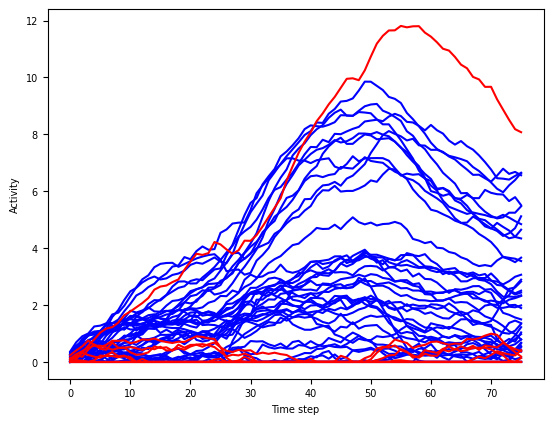

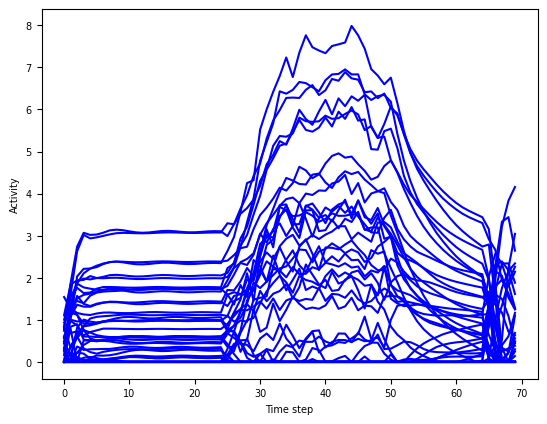

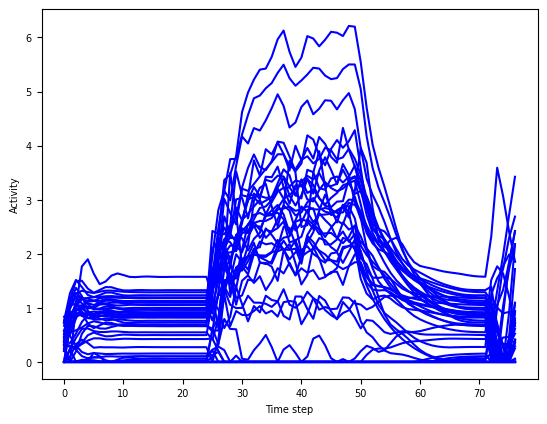

In [13]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = EIRNN_net.rnn.e_size
trial = 3

plt.figure()
_ = plt.plot(activity_dict_EIRNN[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict_EIRNN[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

plt.figure()
_ = plt.plot(activity_dict_leaky[trial], color='blue', label='All Neurons')
plt.xlabel('Time step')
plt.ylabel('Activity')

plt.figure()
_ = plt.plot(activity_dict_sparse[trial], color='blue', label='All Neurons')
plt.xlabel('Time step')
plt.ylabel('Activity')


In [14]:
# Here for each neuron we compute its stimulus period selectivity

mean_activity_sparse = []
mean_activity_leaky = []
mean_activity_EIRNN = []
std_activity_sparse = []
std_activity_leaky = []
std_activity_EIRNN = []
for ground_truth in [0, 1]:
    activity_sparse = np.concatenate(stim_activity_sparse[ground_truth], axis=0)
    mean_activity_sparse.append(np.mean(activity_sparse, axis=0))
    std_activity_sparse.append(np.std(activity_sparse, axis=0))

    activity_leaky = np.concatenate(stim_activity_leaky[ground_truth], axis=0)
    mean_activity_leaky.append(np.mean(activity_leaky, axis=0))
    std_activity_leaky.append(np.std(activity_leaky, axis=0))

    activity_EIRNN = np.concatenate(stim_activity_EIRNN[ground_truth], axis=0)
    mean_activity_EIRNN.append(np.mean(activity_EIRNN, axis=0))
    std_activity_EIRNN.append(np.std(activity_EIRNN, axis=0))

# Compute d'
selectivity_sparse = (mean_activity_sparse[0] - mean_activity_sparse[1])
selectivity_sparse /= np.sqrt((std_activity_sparse[0]**2+std_activity_sparse[1]**2+1e-7)/2)
selectivity_leaky = (mean_activity_leaky[0] - mean_activity_leaky[1])
selectivity_leaky /= np.sqrt((std_activity_leaky[0]**2+std_activity_leaky[1]**2+1e-7)/2)
selectivity_EIRNN = (mean_activity_EIRNN[0] - mean_activity_EIRNN[1])
selectivity_EIRNN /= np.sqrt((std_activity_EIRNN[0]**2+std_activity_EIRNN[1]**2+1e-7)/2)
# Sort index for selectivity, separately for E and I
"""ind_sort_sparse = np.concatenate((np.argsort(selectivity_sparse),
                           np.argsort(selectivity_sparse)))
ind_sort_leaky = np.concatenate((np.argsort(selectivity_leaky),
                           np.argsort(selectivity_leaky)))
ind_sort_EIRNN = np.concatenate((np.argsort(selectivity_EIRNN),
                           np.argsort(selectivity_EIRNN)))"""
ind_sort_sparse = np.argsort(selectivity_sparse)
ind_sort_leaky = np.argsort(selectivity_leaky)
ind_sort_EIRNN = np.concatenate((np.argsort(selectivity_EIRNN[:e_size]),
                           np.argsort(selectivity_EIRNN[e_size:])+e_size))

Text(0, 0.5, 'Number of neurons')

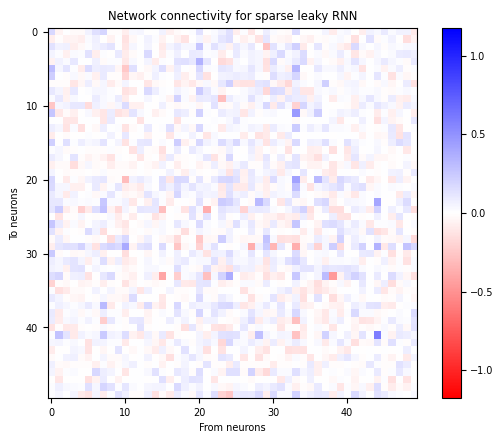

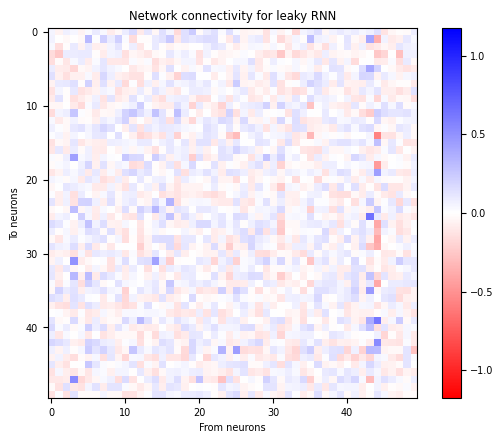

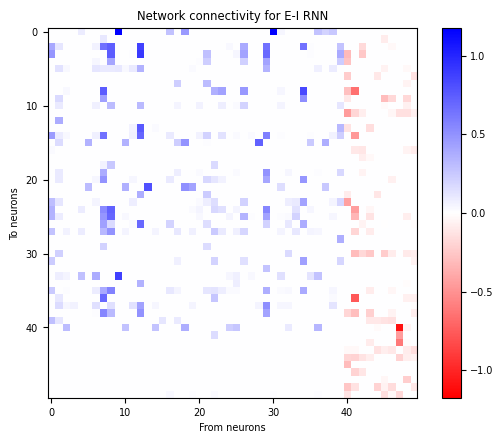

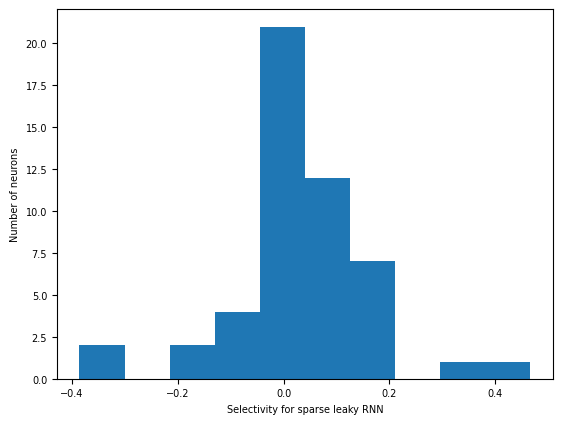

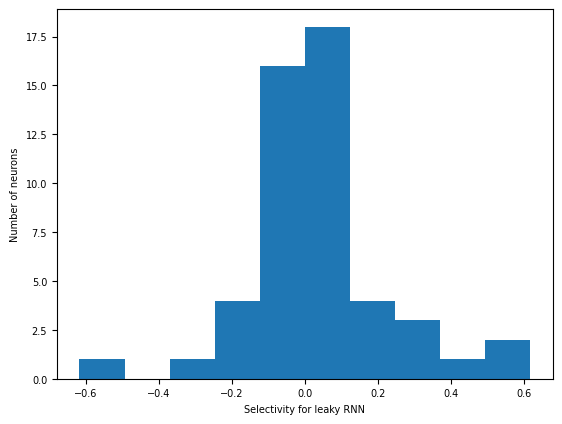

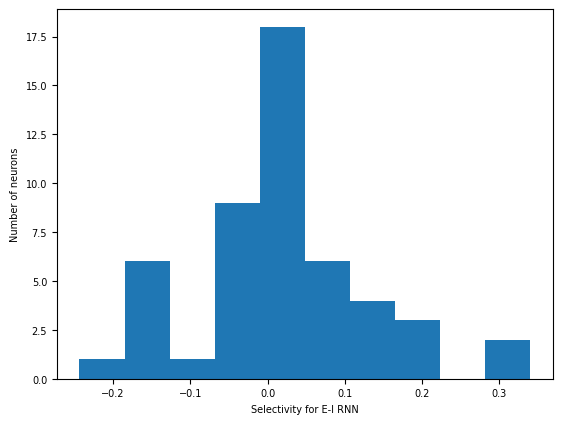

In [15]:
W_sparse = sparse_net.rnn.h2h.weight.detach().numpy()
W_leaky = net.rnn.h2h.weight.detach().numpy()
W_EIRNN = EIRNN_net.rnn.h2h.effective_weight().detach().numpy()

# Sort by selectivity

#W_sparse = W_sparse[:, ind_sort_sparse][ind_sort_sparse, :]
#W_leaky = W_leaky[:, ind_sort_leaky][ind_sort_leaky, :]
#W_EIRNN = W_EIRNN[:, ind_sort_leaky][ind_sort_leaky, :]

wlim_sparse = np.max(np.abs(W_sparse))
wlim_leaky = np.max(np.abs(W_leaky))
wlim_EIRNN = np.max(np.abs(W_EIRNN))

wlims = max(wlim_sparse,wlim_leaky,wlim_EIRNN)

plt.figure()
plt.imshow(W_sparse, cmap='bwr_r', vmin=-wlims, vmax=wlims)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity for sparse leaky RNN')
plt.figure()
plt.imshow(W_leaky, cmap='bwr_r', vmin=-wlims, vmax=wlims)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity for leaky RNN')
plt.figure()
plt.imshow(W_EIRNN, cmap='bwr_r', vmin=-wlims, vmax=wlims)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity for E-I RNN')

plt.figure()
plt.hist(selectivity_sparse)
plt.xlabel('Selectivity for sparse leaky RNN')
plt.ylabel('Number of neurons')

plt.figure()
plt.hist(selectivity_leaky)
plt.xlabel('Selectivity for leaky RNN')
plt.ylabel('Number of neurons')

plt.figure()
plt.hist(selectivity_EIRNN)
plt.xlabel('Selectivity for E-I RNN')
plt.ylabel('Number of neurons')

Shape of the neural activity (Time points, Neurons): (49499, 50)
Shape of the neural activity (Time points, Neurons): (49441, 50)
Shape of the neural activity (Time points, Neurons): [[0.         0.22628637 0.1355472  ... 0.06175561 0.         0.        ]
 [0.         0.3057512  0.28757006 ... 0.01575764 0.         0.        ]
 [0.         0.31536016 0.2063876  ... 0.         0.         0.        ]
 ...
 [4.413683   0.4201555  5.7655845  ... 0.27360064 0.         0.        ]
 [4.420847   0.39457163 6.1890106  ... 0.25993794 0.         0.        ]
 [4.349872   0.52601904 6.5201373  ... 0.29033846 0.         0.        ]]
Shape of the projected activity (Time points, PCs): (49499, 2)
Shape of the projected activity (Time points, PCs): (49441, 2)
Shape of the projected activity (Time points, PCs): (48388, 2)


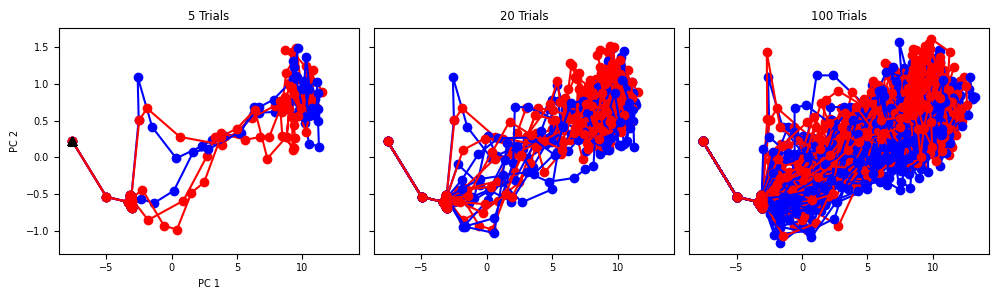

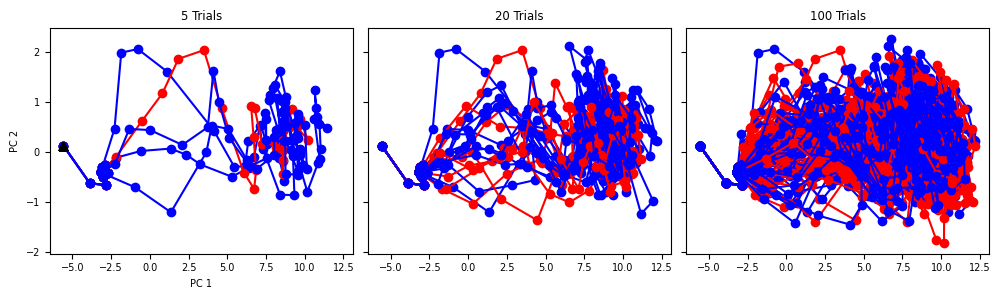

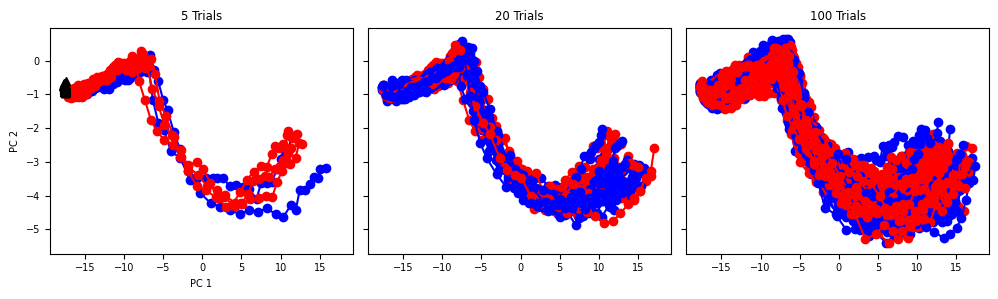

In [16]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse

### Play with different values here to understand the dynamics
plot_until_time = 50



# Concatenate activity data across all trials for PCA
activity_leaky = np.concatenate([activity_dict_leaky[i] for i in range(num_trial)], axis=0)
activity_sparse = np.concatenate([activity_dict_sparse[i] for i in range(num_trial)], axis=0)
activity_EIRNN = np.concatenate([activity_dict_EIRNN[i] for i in range(num_trial)], axis=0)

print('Shape of the neural activity (Time points, Neurons):', activity_leaky.shape)
print('Shape of the neural activity (Time points, Neurons):', activity_sparse.shape)
print('Shape of the neural activity (Time points, Neurons):', activity_EIRNN)

# Initialize PCA and fit it on the activity data
pca_leaky = PCA(n_components=2)
pca_sparse = PCA(n_components=2)
pca_EIRNN = PCA(n_components=2)
# Using 2 components for visualization
pca_leaky.fit(activity_leaky)
activity_pc_leaky = pca_leaky.transform(activity_leaky)
pca_sparse.fit(activity_sparse)
activity_pc_sparse = pca_sparse.transform(activity_sparse)
pca_EIRNN.fit(activity_EIRNN)
activity_pc_EIRNN = pca_EIRNN.transform(activity_EIRNN)
# Transform to lower dimensions (2D) - hint ".transform" could he helpful
print('Shape of the projected activity (Time points, PCs):', activity_pc_leaky.shape)
print('Shape of the projected activity (Time points, PCs):', activity_pc_sparse.shape)
print('Shape of the projected activity (Time points, PCs):', activity_pc_EIRNN.shape)

# Visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc_leaky = pca_leaky.transform(activity_dict_leaky[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos_leaky[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    if i < 5:  # Fewer trials in ax2 for clear visualization
        ax1.plot(activity_pc_leaky[:plot_until_time, 0], activity_pc_leaky[:plot_until_time, 1], 'o-', color=color)
    if i < 20:
        ax2.plot(activity_pc_leaky[:plot_until_time, 0], activity_pc_leaky[:plot_until_time, 1], 'o-', color=color)
    ax3.plot(activity_pc_leaky[:plot_until_time, 0], activity_pc_leaky[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc_leaky[0, 0], activity_pc_leaky[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('5 Trials')
ax2.set_title('20 Trials')
ax3.set_title('100 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3))
for i in range(100):
      activity_pc_sparse = pca_sparse.transform(activity_dict_sparse[i])  # Project each trial's activity
      trial = trial_infos_sparse[i]
      color = 'red' if trial['ground_truth'] == 0 else 'blue'
      if i < 5:  # Fewer trials in ax2 for clear visualization
          ax1.plot(activity_pc_sparse[:plot_until_time, 0], activity_pc_sparse[:plot_until_time, 1], 'o-', color=color)
      if i < 20:
          ax2.plot(activity_pc_sparse[:plot_until_time, 0], activity_pc_sparse[:plot_until_time, 1], 'o-', color=color)
      ax3.plot(activity_pc_sparse[:plot_until_time, 0], activity_pc_sparse[:plot_until_time, 1], 'o-', color=color)

      ax1.plot(activity_pc_sparse[0, 0], activity_pc_sparse[0, 1], '^', color='black')


ax1.set_title('5 Trials')
ax2.set_title('20 Trials')
ax3.set_title('100 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3))
for i in range(100):
      activity_pc_EIRNN = pca_EIRNN.transform(activity_dict_EIRNN[i])  # Project each trial's activity
      trial = trial_infos_EIRNN[i]
      color = 'red' if trial['ground_truth'] == 0 else 'blue'
      if i < 5:  # Fewer trials in ax2 for clear visualization
          ax1.plot(activity_pc_EIRNN[:plot_until_time, 0], activity_pc_EIRNN[:plot_until_time, 1], 'o-', color=color)
      if i < 20:
          ax2.plot(activity_pc_EIRNN[:plot_until_time, 0], activity_pc_EIRNN[:plot_until_time, 1], 'o-', color=color)
      ax3.plot(activity_pc_EIRNN[:plot_until_time, 0], activity_pc_EIRNN[:plot_until_time, 1], 'o-', color=color)

      ax1.plot(activity_pc_EIRNN[0, 0], activity_pc_EIRNN[0, 1], '^', color='black')

ax1.set_title('5 Trials')
ax2.set_title('20 Trials')
ax3.set_title('100 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()
